# Modelling Temperature with a modified Ornstein-Uhlenbeck process

<b> YouTube Tutorial </b> (Published: Jul 20, 2022): https://youtu.be/wMt4ASknkX8

Our goal today is to fit a stochastic process so that we can model the variation as accurately as possible around our estimated temperature model taking into consideration temperature trend and seasonality.

In [ ]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


Parameters:
     a 16.8
     b 3.32e-05
 alpha 5.05
 theta 1.27


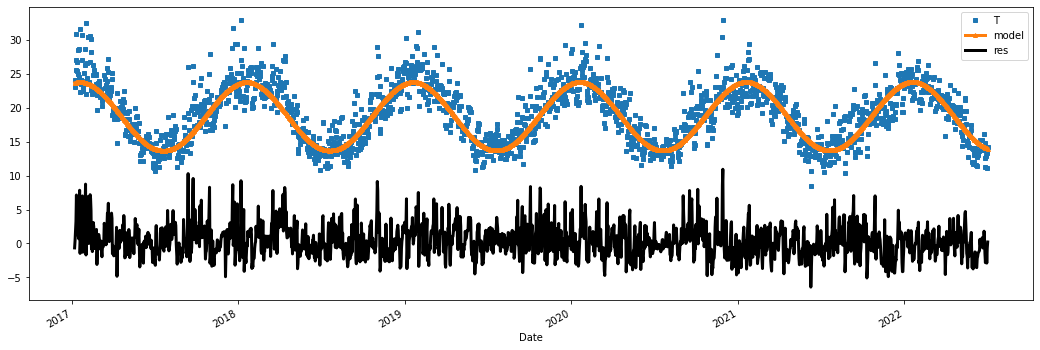

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import norm
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


dir_path = os.path.dirname(os.path.realpath('__file__'))
data_folder = os.path.join(dir_path, 'statistical analysis')
max_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/maximum_temperature.csv')
min_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/minimum_temperature.csv')

def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)

max_temp['Date'] = max_temp.apply(datetime,axis=1)
min_temp['Date'] = min_temp.apply(datetime,axis=1)
max_temp.set_index('Date', inplace=True)
min_temp.set_index('Date', inplace=True)
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)

temps = max_temp.merge(min_temp,how='inner',left_on=['Date'],right_on=['Date'])

def avg_temp(row):
    return (row.Tmax+row.Tmin)/2

temps['T'] = temps.apply(avg_temp,axis=1)

# drop na values here
temps = temps.dropna()

temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

def model(x, params):
    a,b,a1,b1 = params
    omega = 2*np.pi/365.25 #365.25
    theta = np.arctan(a1/b1)
    alpha = np.sqrt( a1**2 + b1**2)
    print('Parameters:\n     a {0:0.3}\n     b {1:0.3}\n alpha {2:0.3}\n theta {3:0.3}'.format(a,b,alpha,theta))
    y_pred = a + b*x + alpha*np.sin(omega*x + theta)
    return y_pred

def model_fit(x, a, b, a1, b1):
    omega = 2*np.pi/365.25
    y_pred = a + b*x + a1*np.cos(omega*x) + b1*np.sin(omega*x)
    return y_pred

if isinstance(temp_t.index , pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index=temp_t.index.map(dt.datetime.toordinal)

params_all, cov = curve_fit(model_fit, xdata = temp_t.index-first_ord, ydata = temp_t['T'], method='lm')

temp_t['model'] = model(temp_t.index-first_ord, params_all)
temp_t['res'] = temp_t['T']-temp_t['model']


if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)

temp_t[-2000:].plot(figsize=(18,6), style=['s','^-','k-'] , markersize=4, linewidth=3 )

## THE MATH
Several authors have opted to model the temperature dynamics with continuous processes which are mean reverting Ornstein-Uhlenbeck (OU) processes
The cyclical nature of the temperature time series justifies the use of a mean-reverting process in modelling its dynamics.

<b>Academic References:</b>
1. [Temperature stochastic modeling and weather derivatives pricing: empirical study with Moroccan data, Mohammed MRAOUA & Driss BARI (2005)](https://www.ajol.info/index.php/afst/article/view/46865)
2. [Weather Derivatives: Pricing and Risk Management Applications, Jon Tindall (2006)](https://actuaries.asn.au/Library/fsf06_paper_tindall_weather%20derivatives.pdf)
3. [Weather Derivatives and the Market Price of Risk, Julius Esunge & James J. Njong (2020)](https://digitalcommons.lsu.edu/cgi/viewcontent.cgi?article=1026&context=josa)

## Why not a normal mean-reverting Ornstein-Uhlenbeck (OU) process?


$\large dT_t = \kappa(\bar{T_t} - T_t)dt + \sigma_t dW_t$

To capture fully the mean-reverting dynamics of the temperature, it is important that we have:

$\large \mathbb{E}[T_t] \approx \bar{T_t}$

## Using Ito-Doeblin formula

However using Ito calculus and solving the Stochastic Differential Equation, we get the following using Ito-Doeblin formula in differential notation:

Ito-Doeblin (where x is an ito process): $df(t,x) = f_t(t, x) dt + f_x(t,x) dx +\frac{1}{2} f_{xx}(t,x) dx dx$

Here the hard part is choosing the $f(x,t)$ to use, following a similar methodology as solving the Cox-Ingersoll-Ross (CIR) interest rate model, we choose:

$\large f(t,x) = e^{\kappa t}x$, where $\large f_t(t,x) = \kappa e^{\kappa t}x, f_x(t,x) = e^{\kappa t}, f_{xx}(t,x) = 0$

This is mainly because of the respective choose of solving a "normal" (non stochastic) integral by the integrating factor method - feel free to google this.


## Solving our SDE

Then we apply Ito-Doeblin to our SDE where our ito process is $T_t$ with dynamics $dT_t$ as described by our mean-reverting SDE:

$\large d(e^{\kappa t} T_t) = \large df(t,T_t) = f_t(t, T_t) dt + f_x(t,T_t) dT_t +\frac{1}{2} f_{xx}(t,T_t) dT_t dT_t$

$\large d(e^{\kappa t} T_t) = \kappa e^{\kappa t} T_t dt + e^{\kappa t} dT_t +\frac{1}{2} (0) dT_t dT_t$ (here we can substitute in dynamics $dT_t$)

$\large d(e^{\kappa t} T_t) = \kappa e^{\kappa t} T_t dt + e^{\kappa t} \kappa(\bar{T_t} - T_t)dt+ e^{\kappa t} \sigma_t dW_t$ (cross out cancelling terms of $\kappa e^{\kappa t} T_t dt$)

$\large d(e^{\kappa t} T_t) = \kappa e^{\kappa t} \bar{T_t} dt+ e^{\kappa t} \sigma_t dW_t$ (take the integral over interval $u \in [s,t] , t>s$)

$\large \int_s^t d(e^{\kappa t} T_t) = e^{\kappa t} T_t - e^{\kappa s} T_s= \int_s^t  \kappa  e^{\kappa u} \bar{T_u} du + \int_s^t e^{\kappa u} \sigma_t dW_u$

$\large e^{\kappa t} T_t = e^{\kappa s} T_s + \int_s^t  \kappa e^{\kappa u} \bar{T_u} du + \int_s^t e^{\kappa u} \sigma_t dW_u$ (change base on Riemann integral to $\large d\bar{T}_t$)

$\large e^{\kappa t} T_t = e^{\kappa s} T_s + \int_s^t  e^{\kappa u} d\bar{T_u} + \int_s^t e^{\kappa u} \sigma_t dW_u$ (divide through LHS by $\large e^{\kappa t}$ factor)

$\large T_t =  T_s e^{-\kappa (t-s)}  + \int_s^t  e^{-\kappa (t-u)} d\bar{T_u} + \int_s^t e^{-\kappa (t-s)} \sigma_t dW_u$

$\large T_t =  T_s e^{-\kappa (t-s)} + \bar{T_t}e^{-\kappa (t-t)} - \bar{T_s} e^{-\kappa (t-s)} + \int_s^t e^{-\kappa (t-s)} \sigma_t dW_u$ (group terms)

$\large T_t =  \bar{T_t} + (T_s -  \bar{T_s}) e^{-\kappa (t-s)}  + \int_s^t e^{-\kappa (t-s)} \sigma_t dW_u$

## Expectation is not Longrun Average Temperature

Because the Ito integral expectation is 0. We arrive at:

$\large \mathbb{E}[T_t] = \bar{T_t} + (T_s -  \bar{T_s}) e^{-\kappa (t-s)}$ which does not equal $\large \bar{T_t}$

This happens because the mean process that the equation is reverting to, $\bar{T}$ , <b>is not constant</b>.

Now remember in the last video when we de-trended and removed seasonality from our DAT series, we were left with some Partial Autocorrelation, indicating that it would be best to model this error with an Autoregressive Model with one lag term AR(1).

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


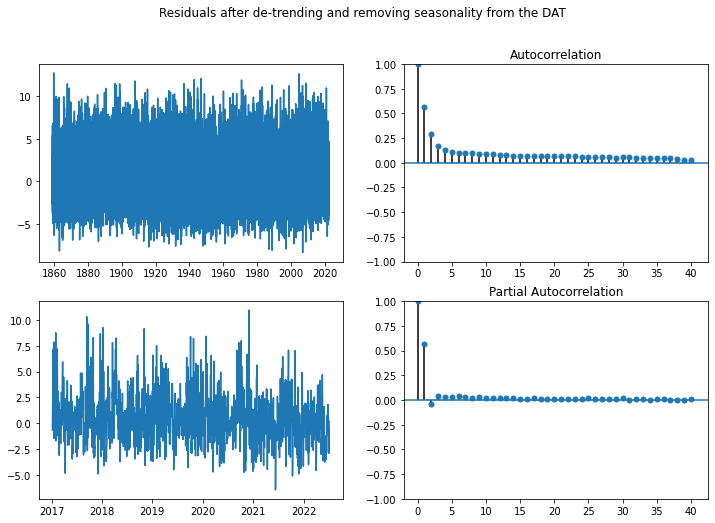

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
fig.suptitle('Residuals after de-trending and removing seasonality from the DAT')
axs[0,0].plot(temp_t['res'])
axs[1,0].plot(temp_t['res'][-2000:])
plot_acf(temp_t['res'], lags=40, ax=axs[0,1])
plot_pacf(temp_t['res'], lags=40, ax=axs[1,1])
plt.show()

## Solving our Issue!

Well this is no coincidence, because as it happens, when we add this AR(1) terms for changes in the seaonsally adjusted mean, $\large \frac{d\bar{T_t}}{dt}$, this will adjust the drift so that the long run mean of the SDE is $\large \bar{T_t}$. Original Work Published by: Doenier & Queruel This problem can be mitigated by adding the term $\large \frac{d\bar{T}}{dt}$. So we arrive at the following SDE:

$\large dT_t = \left[\frac{d\bar{T_t}}{dt} + \kappa(\bar{T_t} - T_t)\right]dt + \sigma_t dW_t$

We could use Ito-doeblin formula again, but it turns out that we can now solved this SDE using the traditional integrating factor method. Multiplying through by $\large e^{\int_0^t \kappa du}$ we obtain, where the left hand side of the above expression is just the differential of a product:

$\large e^{\int_0^t \kappa du} d\bar{T_u} - e^{\int_0^t \kappa du} \kappa(\bar{T_u} - T_u)du + e^{\int_0^t \kappa du}dT_u = e^{\int_0^t \kappa du} \sigma_t dW_u$

$\large d \left[e^{\int_0^t \kappa du} (\bar{T_u} - T_u) \right] = e^{\int_0^t \kappa du} \sigma_t dW_u$

If we consider ito process $\large Z_t = e^{\int_0^t \kappa du} (\bar{T_u} - T_u)$

Then it's dynamics are as the equation above $\large dZ_t = d \left[e^{\int_0^t \kappa du} (\bar{T_u} - T_u) \right] = e^{\int_0^t \kappa du} \sigma_t dW_u$

$\large Z_t = Z_0 - \int_0^t e^{\int_0^t \kappa du} \sigma_t dW_u$

Now if substituting $\large Z_t = e^{\int_0^t \kappa du} (\bar{T_u} - T_u)$ into the equation above with $\large \bar{T_0} = T_0$:

$\large e^{\int_0^t \kappa du} (\bar{T_t} - T_t) = e^{\int_0^t \kappa du}(\bar{T_0} - T_0) - \int_0^t e^{\int_0^t \kappa du} \sigma_t dW_u$

Finally rearranging we get:

$\Large T_t = \bar{T_t} + e^{-\int_0^t \kappa du} \int_0^t e^{\int_0^t \kappa du} \sigma_t dW_u$

$\large \mathbb{E}[T_t] = \bar{T_t}$

## Modified OU Dynamics

We Finally have our dynamics well described and we're convinced that the expectation of this stochastic process is equal to the longrun average (while constantly changing) of our Daily Average Temperature (DAT).

$\large dT_t = \left[\frac{d\bar{T_t}}{dt} + \kappa(\bar{T_t} - T_t)\right]dt + \sigma_t dW_t$

Where our changing average of DAT $\large \bar{T_t}$ is:

$\large \bar{T_t} = 16.8 + (3.32e-05)t + 5.05 sin((\frac{2\pi}{365.25})t + 1.27)$

Where the date <b>01-Jan 1859</b> corresponds with the first ordinal number 0.

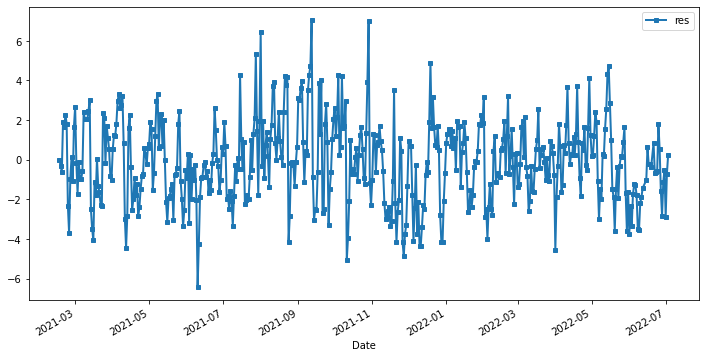

In [ ]:
temp_t[['res']][-500:].plot(figsize=(12,6), style=['s-'] , markersize=4, linewidth=2 )
plt.show()

## Estimating Speed of Mean Reversion

$\large dT_t = \left[\frac{d\bar{T_t}}{dt} + \kappa(\bar{T_t} - T_t)\right]dt + \sigma_t dW_t$

How do we estimate our mean reversion parameter? First, consider the Euler Discretization of our SDE over the interval between $\large t \in [i-1,i]$

Euler Discretization of our SDE over the interval between $\large t \in [i-1,i]$

$\large T_i - T_{i-1} =  \bar{T}_{i} -\bar{T}_{i-1} + \kappa(\bar{T}_{i-1} - T_{i-1}) + \sigma_i z_i$

$\large T_i -\bar{T}_{i}= T_{i-1} + \bar{T}_{i-i} - \kappa(T_{i-1} - \bar{T}_{i-1}) + \sigma_i z_i$

Where $\large z_t \sim N(0,1)$. Now let's create a term for when we de-trend and remove seasonality from our original DAT series. Let's call this transformation $\large \hat{T_t} = \large T_t - \bar{T_t}$, therefore we get:

$\large \hat{T_i} = \hat{T}_{i-1} - \kappa(\hat{T}_{i-1}) + \sigma_i z_i$

This can be modelled as an AR(1) process:

$\large \hat{T_i} = \gamma \hat{T}_{i-1} +e_i$

where $\large \kappa  = 1 - \gamma$, and $\large e_i = \sigma_i z_i$

This is a linear approach to estimating the speed of mean reversion.

## Fitting an Autoregressive model with 1 lag

Now we fit the AR(1) model to the transformed DAT series $\large \hat{T_i}$ (de-trended and removed seasonality).

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


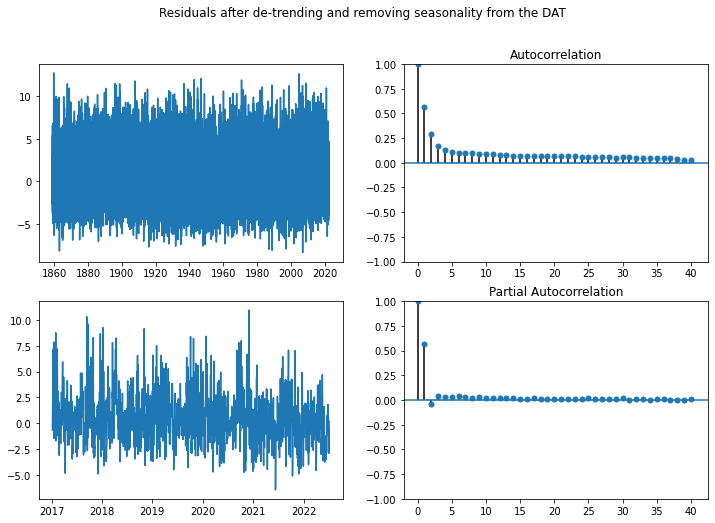

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
fig.suptitle('Residuals after de-trending and removing seasonality from the DAT')
axs[0,0].plot(temp_t['res'])
axs[1,0].plot(temp_t['res'][-2000:])
plot_acf(temp_t['res'], lags=40, ax=axs[0,1])
plot_pacf(temp_t['res'], lags=40, ax=axs[1,1])
plt.show()

In [ ]:
residuals = temp_t['res']
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')

model = AutoReg(residuals, lags=1, old_names=True,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
# res.index = res.index.to_timestamp()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                    res   No. Observations:                59557
Model:                     AutoReg(1)   Log Likelihood             -123373.258
Method:               Conditional MLE   S.D. of innovations              1.921
Date:                Wed, 13 Jul 2022   AIC                         246750.516
Time:                        02:43:13   BIC                         246768.506
Sample:                    01-02-1859   HQIC                        246756.106
                         - 07-03-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res.L1         0.5617      0.003    165.700      0.000       0.555       0.568
                                    Roots                                    
                  Real          Imaginary           M

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:236: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  FutureWarning,


In [ ]:
gamma = coef[0]
kappa = 1 - gamma

print("Kappa is estimated as: {:0.3}".format(kappa))

Kappa is estimated as: 0.438


## Modified OU Dynamics with constants

We Finally have our dynamics well described and we're convinced that the expectation of this stochastic process is equal to the longrun average (while constantly changing) of our Daily Average Temperature (DAT).

$\large dT_t = \left[\frac{d\bar{T_t}}{dt} + 0.438 (\bar{T_t} - T_t)\right]dt + \sigma_t dW_t$

Where our changing average of DAT $\large \bar{T_t}$ is:

$\large \bar{T_t} = 16.8 + (3.32e-05)t + 5.05 sin((\frac{2\pi}{365.25})t + 1.27)$

First derivative does not need finite difference approximation here because the function is differentiable $\large \bar{T'_t}$

$\large \bar{T'_t} = (3.32e-05) + 5.05 (\frac{2\pi}{365.25}) cos((\frac{2\pi}{365.25})t + 1.27)$

Where the date <b>01-Jan 1859</b> corresponds with the first ordinal number 0.
